In [0]:
# datapreprocessing
import numpy as np
import re
import itertools
from collections import Counter

"""
Original taken from https://github.com/dennybritz/cnn-text-classification-tf
"""


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9ㄱ-ㅣ가-힣(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def load_data_and_labels():
    """
    #Loads MR polarity data from files, splits the data into words and generates labels.
    #Returns split sentences and labels.
    """
    # Load data from files    
    positive_examples = list(open("/home/lab/TG/NaverCorpus_5000/inter_pos_data_5000.txt",encoding='utf-8').readlines())
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = list(open("/home/lab/TG/NaverCorpus_5000/inter_neg_data_5000.txt",encoding='utf-8').readlines())
    negative_examples = [s.strip() for s in negative_examples]
    
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    # Generate labels
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]


def pad_sentences(sentences, padding_word="<PAD/>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences


def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]


def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentencs and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return [x, y]


def pre_load_data():
    """
    Loads and preprocessed data for the MR dataset.
    Returns input vectors, labels, vocabulary, and inverse vocabulary.
    """
    # Load and preprocess data
    sentences, labels = load_data_and_labels()
    sentences_padded = pad_sentences(sentences)
    vocabulary, vocabulary_inv = build_vocab(sentences_padded)
    x, y = build_input_data(sentences_padded, labels, vocabulary)
    return [x, y, vocabulary, vocabulary_inv]


def batch_iter(data, batch_size, num_epochs):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data) / batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_data = data[shuffle_indices]
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [0]:
#word2vec
from __future__ import print_function
from gensim.models import word2vec
from os.path import join, exists, split
import os
import numpy as np


def train_word2vec(sentence_matrix, vocabulary_inv,
                   num_features=300, min_word_count=1, context=10):
    """
    Trains, saves, loads Word2Vec model
    Returns initial weights for embedding layer.
   
    inputs:
    sentence_matrix # int matrix: num_sentences x max_sentence_len
    vocabulary_inv  # dict {int: str}
    num_features    # Word vector dimensionality                      
    min_word_count  # Minimum word count                        
    context         # Context window size 
    num_workers     # word2Vec training count
    """
    model_dir = 'models'
    model_name = "{:d}features_{:d}minwords_{:d}context_NaverCorpus".format(num_features, min_word_count, context)
    model_name = join(model_dir, model_name)
    if exists(model_name):
        embedding_model = word2vec.Word2Vec.load(model_name)
        print('Load existing Word2Vec model \'%s\'' % split(model_name)[-1])
    else:
        # Set values for various parameters
        num_workers = 2  # Number of threads to run in parallel
        downsampling = 1e-3  # Downsample setting for frequent words

        # Initialize and train the model
        print('Training Word2Vec model...')
        sentences = [[vocabulary_inv[w] for w in s] for s in sentence_matrix]
        embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                            size=num_features, min_count=min_word_count,
                                            window=context, sample=downsampling)

        # If we don't plan to train the model any further, calling 
        # init_sims will make the model much more memory-efficient.
        embedding_model.init_sims(replace=True)

        # Saving the model for later use. You can load it later using Word2Vec.load()
        if not exists(model_dir):
            os.mkdir(model_dir)
        print('Saving Word2Vec model \'%s\'' % split(model_name)[-1])
        embedding_model.save(model_name)

    # add unknown words
    embedding_weights = {key: embedding_model[word] if word in embedding_model else
                              np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                         for key, word in vocabulary_inv.items()}
    return embedding_weights

"""if __name__ == '__main__':
    #import data_helpers

    print("Loading data...")
    #x, _, _, vocabulary_inv_list = data_helpers.load_data()
    x, _, _, vocabulary_inv_list = load_data()
    vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}
    w = train_word2vec(x, vocabulary_inv)
"""


'if __name__ == \'__main__\':\n    #import data_helpers\n\n    print("Loading data...")\n    #x, _, _, vocabulary_inv_list = data_helpers.load_data()\n    x, _, _, vocabulary_inv_list = load_data()\n    vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}\n    w = train_word2vec(x, vocabulary_inv)\n'

In [0]:
#CNN
"""
Train convolutional network for sentiment analysis on IMDB corpus. Based on
"Convolutional Neural Networks for Sentence Classification" by Yoon Kim
http://arxiv.org/pdf/1408.5882v2.pdf
For "CNN-rand" and "CNN-non-static" gets to 88-90%, and "CNN-static" - 85% after 2-5 epochs with following settings:
embedding_dim = 50          
filter_sizes = (3, 8)
num_filters = 10
dropout_prob = (0.5, 0.8)
hidden_dims = 50
Differences from original article:
- larger IMDB corpus, longer sentences; sentence length is very important, just like data size
- smaller embedding dimension, 50 instead of 300
- 2 filter sizes instead of original 3
- fewer filters; original work uses 100, experiments show that 3-10 is enough;
- random initialization is no worse than word2vec init on IMDB corpus
- sliding Max Pooling instead of original Global Pooling
"""

import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding, Bidirectional, GRU, SimpleRNN
from keras.layers.merge import Concatenate
from keras.datasets import imdb
from keras.datasets import reuters
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
np.random.seed(0)

# ---------------------- Parameters section -------------------
#
# Model type. See Kim Yoon's Convolutional Neural Networks for Sentence Classification, Section 3
model_type = "CNN-static"  # CNN-rand|CNN-non-static|CNN-static

# Data source
data_source = "local_dir"  # keras_data_set|local_dir

# Model Hyperparameters
embedding_dim = 64
filter_sizes = (3, 8)
num_filters = 10
dropout_prob = (0.5, 0.8)
hidden_dims = 64

# Training parameters
batch_size = 64
num_epochs = 50

# Prepossessing parameters
sequence_length = 400
max_words = 10000   # Reuters = 1000, IMDB = 5000

# Word2Vec parameters (see train_word2vec)
min_word_count = 1
context = 10

#
# ---------------------- Parameters end -----------------------


def load_data(data_source):
    assert data_source in ["keras_data_set", "local_dir"], "Unknown data source"
    if data_source == "keras_data_set":
        # IMDB
        #(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=None, oov_char=None, index_from=None)
        # Reuters
        (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words, start_char=None,oov_char=None, index_from=None)

        x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post", truncating="post")
        x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post", truncating="post")

        ######## IMDB #########
        """
        vocabulary = imdb.get_word_index()
        vocabulary = imdb.get_word_index()
        vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
        vocabulary_inv[0] = "<PAD/>"
        """
        ######## IMDB #########
        
        ######## Reuters ########
        vocabulary = reuters.get_word_index()
        vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
        vocabulary_inv[0] = "<PAD/>"
        y_train = to_categorical(y_train) # 형태는 (8982, 46)
        y_test = to_categorical(y_test) # 형태는 (2246, 46)
        ######## Reuters ########
        
    else:
        x, y, vocabulary, vocabulary_inv_list = pre_load_data()
        vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}
        y = y.argmax(axis=1)

        # Shuffle data
        shuffle_indices = np.random.permutation(np.arange(len(y)))
        x = x[shuffle_indices]
        y = y[shuffle_indices]
        train_len = int(len(x) * 0.5)
        x_train = x[:train_len]
        y_train = y[:train_len]
        x_test = x[train_len:]
        y_test = y[train_len:]

    return x_train, y_train, x_test, y_test, vocabulary_inv


# Data Preparation
print("Load data...")
x_train, y_train, x_test, y_test, vocabulary_inv = load_data(data_source)

if sequence_length != x_test.shape[1]:
    print("Adjusting sequence length for actual size")
    sequence_length = x_test.shape[1]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

# Prepare embedding layer weights and convert inputs for static model
print("Model type is", model_type)
if model_type in ["CNN-non-static", "CNN-static"]:
    embedding_weights = train_word2vec(np.vstack((x_train, x_test)), vocabulary_inv, num_features=embedding_dim,
                                       min_word_count=min_word_count, context=context)
    if model_type == "CNN-static":
        x_train = np.stack([np.stack([embedding_weights[word] for word in sentence]) for sentence in x_train])
        x_test = np.stack([np.stack([embedding_weights[word] for word in sentence]) for sentence in x_test])
        print("x_train static shape:", x_train.shape)
        print("x_test static shape:", x_test.shape)

elif model_type == "CNN-rand":
    embedding_weights = None
else:
    raise ValueError("Unknown model type")

# Build model
if model_type == "CNN-static":
    input_shape = (sequence_length, embedding_dim)
else:
    input_shape = (sequence_length,)

model_input = Input(shape=input_shape)

# Static model does not have embedding layer
if model_type == "CNN-static":
    z = model_input
else:
    z = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")(model_input)

z = Dropout(dropout_prob[0])(z)
z = Bidirectional(GRU(32, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(z)
# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)      # binary classfication (IMDB, NAVER Corpus)
#model_output = Dense(46, activation="softmax")(z)    # multi calssfication


model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])         # binary classfication (IMDB, NAVER Corpus)
#model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics=["accuracy"]) # multi calssfication
model.summary()

# Initialize weights with word2vec
if model_type == "CNN-non-static":
    weights = np.array([v for v in embedding_weights.values()])
    print("Initializing embedding layer with word2vec weights, shape", weights.shape)
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights([weights])

# Train the model
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=1)


Using TensorFlow backend.


Load data...
Adjusting sequence length for actual size
x_train shape: (135000, 87)
x_test shape: (15000, 87)
Vocabulary Size: 295438
Model type is CNN-static
Load existing Word2Vec model '64features_1minwords_10context_NaverCorpus'


/home/lab/.conda/envs/tensorflow_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:54: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/lab/.conda/envs/tensorflow_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:54: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


x_train static shape: (135000, 87, 64)
x_test static shape: (15000, 87, 64)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 87, 64)       0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 87, 64)       0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 87, 64)       18624       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 85, 10)       1930        bidirectional_1[0][0]            
_________________________________

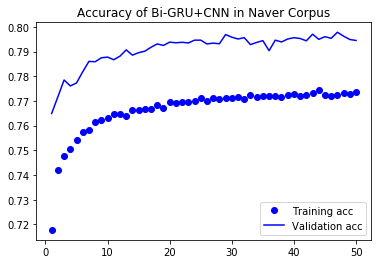

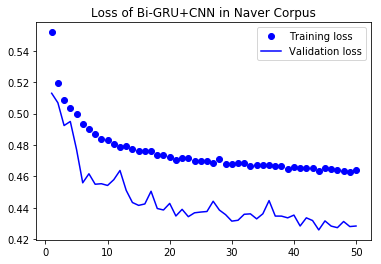

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Accuracy of Bi-GRU+CNN in Naver Corpus')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Loss of Bi-GRU+CNN in Naver Corpus')
plt.legend()

plt.show()

In [0]:
model.save('Bi-GRU + CNN + NaverCorpus + nonstatic.h5')

import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('/home/lab/TG/NaverCorpus', 'w'))